In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from itertools import product
from tqdm import tqdm

In [3]:
r800 = pd.read_csv('cutting/r800.csv', header=None, names=['a', 'b', 'score'])
r850 = pd.read_csv('cutting/r850.csv', header=None, names=['a', 'b', 'score'])
r1000 = pd.read_csv('cutting/r1000.csv', header=None, names=['a', 'b', 'score'])
r1100 = pd.read_csv('cutting/r1100.csv', header=None, names=['a', 'b', 'score'])
r1200 = pd.read_csv('cutting/r1200.csv', header=None, names=['a', 'b', 'score'])

print('30000 w kole o średnicy 800')
print('r800')
print(r800)

print('850 nie wpływa na punktację')
print('r850')
print(r850)

print('17500 w kole o średnicy 1000')
print('r1000')
print(r1000)

print('25000 w kole o średnicy 1100')
print('r1100')
print(r1100)

print('30000 w kole o średnicy 1200')
print('r1200')
print(r1200)

30000 w kole o średnicy 800
r800
     a    b  score
0  250  120    100
1  320  160    500
2  250  160    600
3  150  120     40
4  400   30    400
850 nie wpływa na punktację
r850
     a    b  score
0   10  120    120
1  120   10    150
2  400   20   1200
3  300   30   1200
4  120  120   1200
5  100  100    900
6  450   80  11000
17500 w kole o średnicy 1000
r1000
     a    b  score
0  200  120    200
1  200  160    300
2  250  160    500
3  100  120     40
25000 w kole o średnicy 1100
r1100
     a    b  score
0  250  120    100
1  120  360    300
2  250  160    600
3  150  120     40
30000 w kole o średnicy 1200
r1200
     a    b  score
0  200  120    200
1  200  160    300
2  250  160    500
3  100  120     40


In [4]:
class genetic_cutting:
	def __init__(self, task_file, diameter, population_size, initiation_size):
		self.population_size = population_size

		self.load_task_file(task_file, diameter)
		self.initialize_population(population_size, initiation_size)

	def load_task_file(self, file_name, diameter):
		self.diameter = diameter
		self.data = pd.read_csv(file_name, header=None).to_numpy()

	def initialize_population(self, size, initiation_size):
		self.population = []
		for i in range(size):
			speciment = self.get_random_rectangle(initiation_size)
			legal, _ = self.check_legality(speciment)
			self.population.append(legal)
		
	def check_stop_criterion(self):
		pass

	def selection(self, selection_type, elite_ratio=None, draft_size=None):
		def roulette(fitness, population):
			population_size = len(population)
			prob = fitness / np.sum(fitness)

			parent_A_idx = np.random.choice(population_size, size=population_size, p=prob)
			parent_B_idx = np.random.choice(population_size, size=population_size, p=prob)

			parent_A = [population[i] for i in parent_A_idx]
			parent_B = [population[i] for i in parent_B_idx]

			return parent_A, parent_B
		
		def tournament(fitness, population, draft_size):
			population_size = len(population)

			candidate_A = np.random.choice(population_size, size=(population_size, draft_size))
			candidate_B = np.random.choice(population_size, size=(population_size, draft_size))
			
			best_candidate_A = np.argmax(fitness[candidate_A], axis=1)
			best_candidate_B = np.argmax(fitness[candidate_B], axis=1)

			best_candidate_A_idx = candidate_A[np.arange(len(candidate_A)), best_candidate_A]
			best_candidate_B_idx = candidate_B[np.arange(len(candidate_B)), best_candidate_B]

			parent_A = [population[i] for i in best_candidate_A_idx]
			parent_B = [population[i] for i in best_candidate_B_idx]

			return parent_A, parent_B

		def rank(fitness, population):
			population_size = len(population)
			cutoff = 0.5
			grace = 0.2
			prob_lambda = -np.log(grace)/(cutoff*self.population_size)

			ranks = np.argsort(-fitness)
			ordered_population = [population[i] for i in ranks]
			positions = np.arange(population_size)
			prob = np.exp(-prob_lambda*positions)
			prob /= np.sum(prob)

			parent_A_idx = np.random.choice(population_size, size=population_size, p=prob)
			parent_B_idx = np.random.choice(population_size, size=population_size, p=prob)

			parent_A = [ordered_population[i] for i in parent_A_idx]
			parent_B = [ordered_population[i] for i in parent_B_idx]

			return parent_A, parent_B

		def elite(fitness, elite_ratio):
			ranks = np.argsort(fitness)
			ordered_population = [self.population[i] for i in ranks]
			elite_size = int(self.population_size * elite_ratio)

			return ordered_population[:elite_size], ordered_population[elite_size:]

		fitness = self.check_score(self.population)
		if elite_ratio != None:
			elite_parents, rest_population = elite(fitness, elite_ratio)
			fitness = self.check_score(rest_population)
			match selection_type:
				case 'roulette':
					parent_A, parent_B = roulette(fitness, rest_population)
					parent_A += elite_parents
					parent_B += elite_parents
				case 'tournament':
					parent_A, parent_B = tournament(fitness, rest_population, draft_size)
					parent_A += elite_parents
					parent_B += elite_parents
				case 'rank':
					parent_A, parent_B = rank(fitness, rest_population)
					parent_A += elite_parents
					parent_B += elite_parents
		else:
			match selection_type:
				case 'roulette':
					parent_A, parent_B = roulette(fitness, self.population)
				case 'tournament':
					parent_A, parent_B = tournament(fitness, self.population, draft_size)
				case 'rank':
					parent_A, parent_B = rank(fitness, self.population)

		return (parent_A, parent_B)

	def crossbreed(self, crossbreed_type, parents_A, parents_B):
		def naive(parent_A, parent_B):
			child_rough = np.vstack([parent_A, parent_B])
			np.random.shuffle(child_rough)
			legal, _ = self.check_legality(child_rough)

			return legal
		
		new_population = []
		match crossbreed_type:
			case 'naive':
				for i in range(len(parents_A)): new_population.append(naive(parents_A[i], parents_B[i]))
		self.population = new_population

	def mutation(self, mutation_prob, max_translation_step, translation_variants_number, addition_variants_number):
		# pick speciments and mutation type
		mutation_choice = np.random.choice(self.population_size, size=int(mutation_prob*self.population_size))
		mutation_type = np.random.randint(0, 4, len(mutation_choice))
		add_idx = mutation_choice[np.where(mutation_type == 0)]
		translate_idx = mutation_choice[np.where(mutation_type == 1)]
		rotate_idx = mutation_choice[np.where(mutation_type == 2)]
		deletion_idx = mutation_choice[np.where(mutation_type == 3)]

		for idx in add_idx:
			# print('adding')
			speciment = self.population[idx]

			addition_candidates = self.get_random_rectangle(addition_variants_number)

			legal_addition, _ = self.check_mutation_legality(speciment, addition_candidates, mutation_type='add')
			if legal_addition is not None:
				self.population[idx] = np.vstack([speciment, legal_addition])
			
		for idx in translate_idx:
			# print('translating')
			speciment = self.population[idx]
			speciment_size = len(speciment)

			translation_candidates = np.zeros(shape=(speciment_size*translation_variants_number, 5), dtype=int)
			translation_step = np.random.randint(-max_translation_step, max_translation_step, size=(speciment_size*translation_variants_number, 2))
			translation_candidates[:, [0,1]] = translation_step
			translation_candidates += np.tile(speciment, (translation_variants_number, 1))
			
			legal_translation, translation_idx = self.check_mutation_legality(speciment, translation_candidates, mutation_type='modify')
			if legal_translation is not None:
				translation_idx %= speciment_size
				# print(translation_idx)
				self.population[idx][translation_idx] = legal_translation

		for idx in rotate_idx:
			# print('rotating')
			speciment = self.population[idx]

			rotation_candidates = speciment[:, [0,1,3,2,4]]

			legal_rotation, rotation_idx = self.check_mutation_legality(speciment, rotation_candidates, mutation_type='modify')
			if legal_rotation is not None:
				if rotation_idx >= len(speciment):
					print("wybrano index rotacji większy niż długość osobnika: rotation_idx=", rotation_idx, 'len(speciment)', len(speciment))
					return speciment, legal_rotation, rotation_idx

				self.population[idx][rotation_idx] = legal_rotation

		for idx in deletion_idx:
			speciment = self.population[idx]

			deletion_candidate_idx = np.random.randint(0, len(speciment))

			self.population[idx] = np.delete(speciment, deletion_candidate_idx, axis=0)

	def evolve(self, iterations_num, selection_type, draft_size, elite_ratio, crossbreed_type, mutation_prob, max_translation_step, translation_variants_number, addition_variants_number):
		best_history = []
		mean_history = []

		best_score = 0
		for i in range(iterations_num):
			parents_A, parents_B = self.selection(selection_type=selection_type, elite_ratio=elite_ratio, draft_size=draft_size)
			self.crossbreed(crossbreed_type=crossbreed_type, parents_A=parents_A, parents_B=parents_B)
			self.mutation(mutation_prob=mutation_prob, max_translation_step=max_translation_step, translation_variants_number=translation_variants_number, addition_variants_number=addition_variants_number)
			score = self.check_score(self.population)
			if np.max(score) > best_score:
				best_score = np.max(score)
				best_speciment = self.population[np.argmax(score)]
			best_history.append(np.max(score))
			mean_history.append(np.mean(score))

		return best_history, mean_history, best_speciment

	def get_random_rectangle(self, size):
		# get random rectagles
		idx = (np.random.uniform(0, len(self.data), size)).astype(int)
		rectangles = self.data[idx]
		# rotate some
		rotation = np.random.rand(size) > 0.5
		rotated = rectangles[rotation]
		rotated[:, [0, 1]] = rotated[:, [1, 0]]
		rectangles[rotation] = rotated
		# get random positions
		theta = np.random.uniform(0, 2*np.pi, size)
		r = np.random.uniform(0, self.diameter/2, size)
		p = (r * np.cos(theta)).astype(int)
		q = (r * np.sin(theta)).astype(int)
		rectangles = np.column_stack([p, q, rectangles])
		# correct circuit border
		quarter1 = np.where(theta < np.pi/2)
		rectangles[quarter1, 0] -= rectangles[quarter1, 2]
		rectangles[quarter1, 1] -= rectangles[quarter1, 3]

		quarter2 = np.where((theta > np.pi/2) & (theta < np.pi))
		rectangles[quarter2, 1] -= rectangles[quarter2, 3]

		quarter4 = np.where(theta > 3/2*np.pi)
		rectangles[quarter4, 0] += rectangles[quarter4, 2]

		return rectangles
	
	def check_mutation_legality(self, speciment, candidates, mutation_type):
		# shuffle candidates
		candidates_num = len(candidates)
		shuffle_map = np.random.permutation(np.arange(candidates_num))
		shuffled_candidates = candidates[shuffle_map]
		
		correct_candidate_shuffled_idx = None
		for i in range(candidates_num):
			# get candidate
			p = shuffled_candidates[i, 0]
			q = shuffled_candidates[i, 1]
			a = shuffled_candidates[i, 2]
			b = shuffled_candidates[i, 3]
			# print('checking candidate', i, p ,q)
			# if candidate beyond circle, skip
			if np.sqrt(p**2 + q**2) > self.diameter/2: continue
			if np.sqrt((p+a)**2 + q**2) > self.diameter/2: continue
			if np.sqrt(p**2 + (q+b)**2) > self.diameter/2: continue
			if np.sqrt((p+a)**2 + (q+b)**2) > self.diameter/2: continue
			# print('no boundary error')
			overlap_present = False
			for j in range(len(speciment)):
				# if modification candidate, don't check with itself
				if mutation_type == 'modify' and shuffle_map[i]%len(speciment)==j:
					# print('skipped')
					continue

				p2 = speciment[j, 0]
				q2 = speciment[j, 1]
				a2 = speciment[j, 2]
				b2 = speciment[j, 3]
				# print('checking speciment', j, p2, q2)
				# if candidate overlaps, skip
				if p < p2: span_x = a
				else: span_x = a2
				x_overlap = np.abs(p - p2) < span_x
				if q < q2: span_y = b 
				else: span_y = b2
				y_overlap = np.abs(q - q2) < span_y
				if x_overlap and y_overlap:
					# print('overlap present')
					overlap_present = True
					break
			
			# if correct candidate found, stop
			if overlap_present == True: 
				continue
			else:
				# print('correct found')
				correct_candidate_shuffled_idx = i
				break

		# if correct candidate found, return with original index
		if correct_candidate_shuffled_idx != None:
			correct_candidate = shuffled_candidates[correct_candidate_shuffled_idx].reshape(1, 5)
			correct_candidate_idx = shuffle_map[correct_candidate_shuffled_idx]

			return correct_candidate, correct_candidate_idx
		else:
			return None, None

	def check_legality(self, rectangles):
		bad = []
		good = []
		# circle boundary check
		for i in range(len(rectangles)):
			p = rectangles[i, 0]
			q = rectangles[i, 1]
			a = rectangles[i, 2]
			b = rectangles[i, 3]

			if np.sqrt(p**2 + q**2) > self.diameter/2: bad.append(i)
			if np.sqrt((p+a)**2 + q**2) > self.diameter/2: bad.append(i)
			if np.sqrt(p**2 + (q+b)**2) > self.diameter/2: bad.append(i)
			if np.sqrt((p+a)**2 + (q+b)**2) > self.diameter/2: bad.append(i)
		# overlap check
		for i in range(len(rectangles)):
			if i in bad: continue
			p1 = rectangles[i, 0]
			q1 = rectangles[i, 1]
			a1 = rectangles[i, 2]
			b1 = rectangles[i, 3]

			for j in range(len(rectangles)-1, i, -1):
				if j in bad: continue
				p2 = rectangles[j, 0]
				q2 = rectangles[j, 1]
				a2 = rectangles[j, 2]
				b2 = rectangles[j, 3]
				
				if p1 < p2: span_x = a1 
				else: span_x = a2
				x_overlap = np.abs(p1 - p2) < span_x
				if q1 < q2: span_y = b1 
				else: span_y = b2
				y_overlap = np.abs(q1 - q2) < span_y
				if x_overlap and y_overlap:
					bad.append(j)
			
			good.append(i)
		if len(rectangles)-1 not in bad: good.append(len(rectangles)-1)

		return rectangles[good], rectangles[bad]

	def check_score(self, population):
		population_size = len(population)
		score = np.empty(population_size, int)
		for i in range(population_size):
			speciment = population[i]
			score[i] = np.sum(speciment[:, 4])

		return score

def draw_speciment(diameter, speciment):
	if speciment.ndim == 1:
		speciment = speciment.reshape(1, 5)

	p = speciment[:, 0]
	q = speciment[:, 1]
	a = speciment[:, 2]
	b = speciment[:, 3]
	
	fig, ax = plt.subplots()
	ax.set_aspect('equal')
	ax.set_xlim(-diameter/2 - 100, diameter/2 + 100)
	ax.set_ylim(-diameter/2 - 100, diameter/2 + 100)
	circle = Circle((0,0), diameter/2, edgecolor='black', facecolor='none', linewidth=1)
	ax.add_patch(circle)
	
	for i in range(len(speciment)):
		rectange = Rectangle((p[i], q[i]), a[i], b[i],
					edgecolor='blue', facecolor='lightblue')
		ax.add_patch(rectange)

	plt.grid(True)
	plt.show()

def grid_search(param_grid, task_file, diameter):
	best_speciment_record = []
	best_history_record = []
	mean_history_record = []

	for config in tqdm(param_grid, desc='Progress'):
		(population_size,
   		initiation_size,
        iterations,
        selection,
        draft_size,
        elite_ratio,
        crossbreed_type,
        mutation_prob,
        max_translation_step,
        translation_variants_number,
        addition_variants_number) = config

		test = genetic_cutting(task_file=task_file, diameter=diameter,
                           population_size=population_size, initiation_size=initiation_size)
		
		best_history, mean_history, best_speciment = test.evolve(
			iterations_num=iterations,
			selection_type=selection,
			draft_size=draft_size,
			elite_ratio=elite_ratio,
			crossbreed_type=crossbreed_type,
			mutation_prob=mutation_prob,
			max_translation_step=max_translation_step,
			translation_variants_number=translation_variants_number,
			addition_variants_number=addition_variants_number)
		
		best_speciment_record.append(best_speciment)
		best_history_record.append(best_history)
		mean_history_record.append(mean_history)

	return best_history_record, mean_history_record, best_speciment_record
		
def check_solution(diameter, best_history, mean_history, best_speciment):
	draw_speciment(diameter, best_speciment)

	print('best_best_iteration', np.argmax(best_history), 'score', np.max(best_history))
	print('best_mean_iteration', np.argmax(mean_history), 'score', np.max(mean_history))

	x = np.arange(0, len(best_history), 1)
	plt.plot(x, best_history, label='best', color='red')
	plt.plot(x, mean_history, label='mean', color='orange')
	plt.xlabel('Iterations')
	plt.ylabel('Score')
	plt.title('Mean and best score in iterations')
	plt.legend()
	plt.grid(True)
	plt.show()

# Eksploracja parametrów (r800)

In [156]:
population_size_space = [75, 125]
initiation_size_space = [250, 750]
iterations_space = [30]

other_selection_space = ['roulette', 'rank']
other_draft_size_space = [None]

tournament_selection_space = ['tournament']
tournament_draft_size_space = [2, 3]

elite_ratio_space = [None, 0.2]
crossbreed_type_space = ['naive']
mutation_prob_space = [0.3, 0.6]
max_translation_step_space = [20, 80]
translation_variants_number_space = [50, 250]
addition_variants_number_space = [50, 250]

other_param_grid = list(product(
    population_size_space,
    initiation_size_space,
    iterations_space,
    other_selection_space,
    other_draft_size_space,
    elite_ratio_space,
    crossbreed_type_space,
    mutation_prob_space,
    max_translation_step_space,
    translation_variants_number_space,
    addition_variants_number_space,
))

tournament_param_grid = list(product(
    population_size_space,
    initiation_size_space,
    iterations_space,
    tournament_selection_space,
    tournament_draft_size_space,
    elite_ratio_space,
    crossbreed_type_space,
    mutation_prob_space,
    max_translation_step_space,
    translation_variants_number_space,
    addition_variants_number_space,
))

param_grid = other_param_grid + tournament_param_grid

combinations_count = len(param_grid)
print('Liczba kombinacji:', combinations_count)
print('Czas dla 30 iteracji(21s):', combinations_count * 21 / 60 / 60, 'h')

Liczba kombinacji: 512
Czas dla 30 iteracji(21s): 2.9866666666666664 h


In [90]:
best_history_record, mean_history_record, best_speciment_record = grid_search(param_grid = param_grid, task_file='cutting/r800.csv', diameter=1600)

Progress: 100%|██████████| 512/512 [3:45:12<00:00, 26.39s/it]  


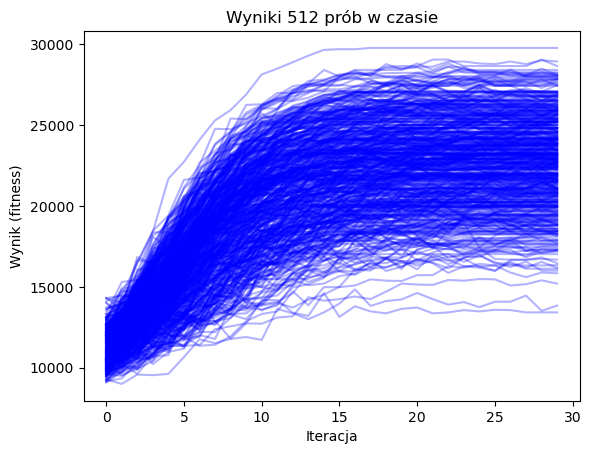

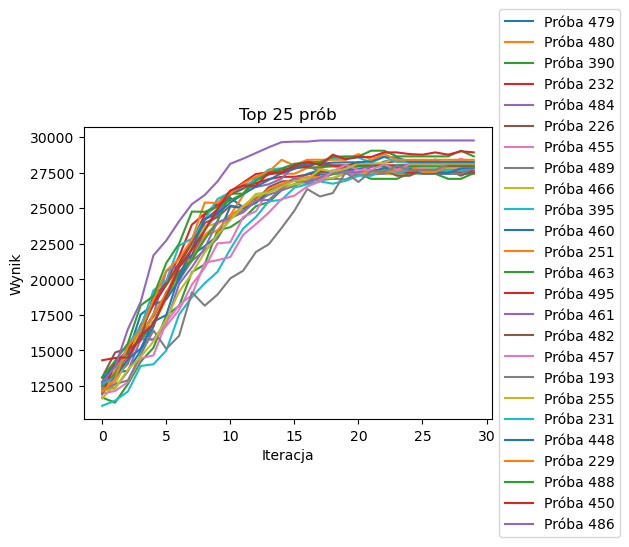

population_size ['125' 125 125 125 125 125 125 125 '125' 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125 125]
initiation_size ['750' 750 250 750 750 750 750 750 '750' 250 750 750 750 750 750 750 750
 750 750 750 750 750 750 750 750]
iterations_num ['30' 30 30 30 30 30 30 30 '30' 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30]
selection_type ['tournament' 'tournament' 'tournament' 'rank' 'tournament' 'rank'
 'tournament' 'tournament' 'tournament' 'tournament' 'tournament' 'rank'
 'tournament' 'tournament' 'tournament' 'tournament' 'tournament'
 'roulette' 'rank' 'rank' 'tournament' 'rank' 'tournament' 'tournament'
 'tournament']
draft_size ['2' 3 2 None 3 None 2 3 '2' 2 2 None 2 3 2 3 2 None None None 2 None 3 2
 3]
elite_ratio ['0.2' None None None None None None None '0.2' None None 0.2 None None
 None None None None 0.2 None None None None None None]
crossbreed_type ['naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive'
 'naive' 'naive' 'naive' 'naive

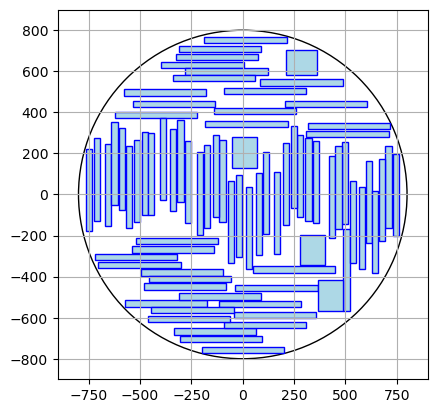

best_best_iteration 17 score 29760
best_mean_iteration 21 score 29760.0


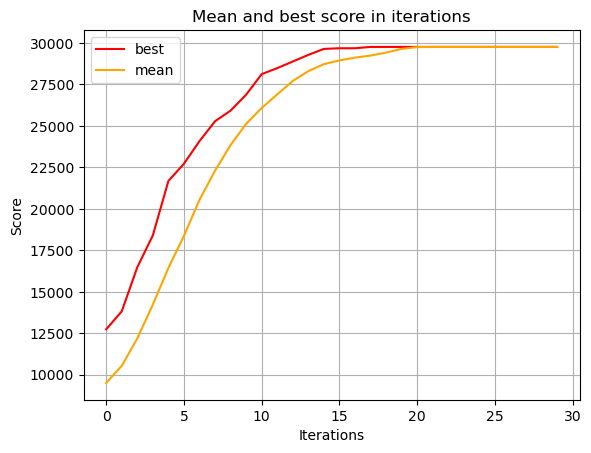

In [157]:
for i, run in enumerate(best_history_record):
    plt.plot(run, alpha=0.3, color='blue')

plt.xlabel("Iteracja")
plt.ylabel("Wynik (fitness)")
plt.title("Wyniki 512 prób w czasie")
plt.show()

final_scores = [run[-1] for run in best_history_record]
top_indices = np.argsort(final_scores)[-25:]  
top_params = np.empty(shape=(25, 11), dtype=object)

for i, top_indice in enumerate(top_indices):
    plt.plot(best_history_record[top_indice], label=f"Próba {top_indice}")
    top_params[i, :] = np.array(param_grid[top_indice]).reshape((1, 11))

plt.xlabel("Iteracja")
plt.ylabel("Wynik")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title("Top 25 prób")
plt.show()

print('population_size', top_params[:, 0])
print('initiation_size', top_params[:, 1])
print('iterations_num', top_params[:, 2])
print('selection_type', top_params[:, 3])
print('draft_size', top_params[:, 4])
print('elite_ratio', top_params[:, 5])
print('crossbreed_type', top_params[:, 6])
print('mutation_prob', top_params[:, 7])
print('max_translation_step', top_params[:, 8])
print('translation_variants_number', top_params[:, 9])
print('addition_variants_number', top_params[:, 10])

idx = top_indices[24]
check_solution(1600, best_history_record[idx], mean_history_record[idx], best_speciment_record[idx])

In [6]:
population_size_space = [125]
initiation_size_space = [750]
iterations_space = [50]
selection_space = ['tournament']
draft_size_space = [2]
elite_ratio_space = [None]
crossbreed_type_space = ['naive']
mutation_prob_space = [0.45]
max_translation_step_space = [20, 30, 40, 50]
translation_variants_number_space = [50, 100, 150, 250]
addition_variants_number_space = [50, 100, 150, 250]

param_grid = list(product(
    population_size_space,
    initiation_size_space,
    iterations_space,
    selection_space,
    draft_size_space,
    elite_ratio_space,
    crossbreed_type_space,
    mutation_prob_space,
    max_translation_step_space,
    translation_variants_number_space,
    addition_variants_number_space,
))

combinations_count = len(param_grid)
print('Liczba kombinacji:', combinations_count)
print('Czas dla 30 iteracji(65s):', combinations_count * 65 / 60 / 60, 'h')

Liczba kombinacji: 64
Czas dla 30 iteracji(65s): 1.1555555555555554 h


In [165]:
best_history_record, mean_history_record, best_speciment_record = grid_search(param_grid = param_grid, task_file='cutting/r800.csv', diameter=1600)

Progress: 100%|██████████| 64/64 [1:29:15<00:00, 83.69s/it]


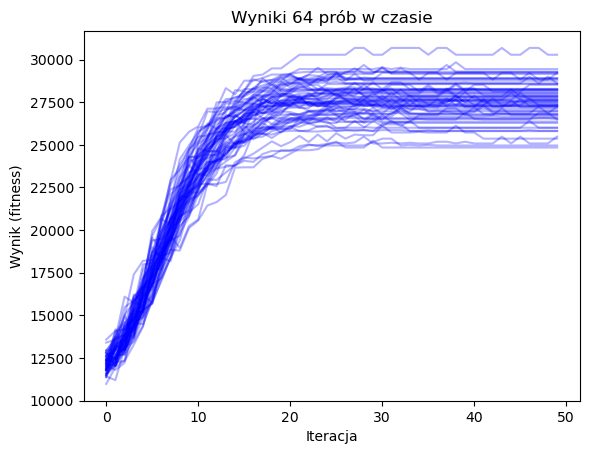

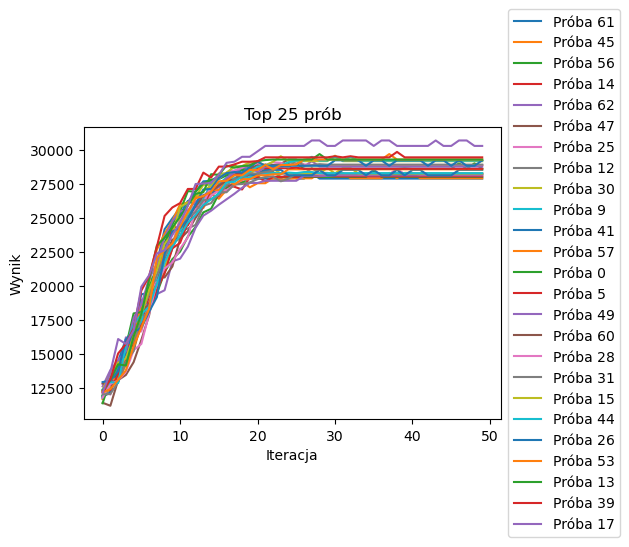

population_size [125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125 125
 125 125 125 125 125 125 125]
initiation_size [750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750 750
 750 750 750 750 750 750 750]
iterations_num [50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50]
selection_type ['tournament' 'tournament' 'tournament' 'tournament' 'tournament'
 'tournament' 'tournament' 'tournament' 'tournament' 'tournament'
 'tournament' 'tournament' 'tournament' 'tournament' 'tournament'
 'tournament' 'tournament' 'tournament' 'tournament' 'tournament'
 'tournament' 'tournament' 'tournament' 'tournament' 'tournament']
draft_size [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
elite_ratio [None None None None None None None None None None None None None None
 None None None None None None None None None None None]
crossbreed_type ['naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive'
 'naive' 'naive' 'naive' 'naive

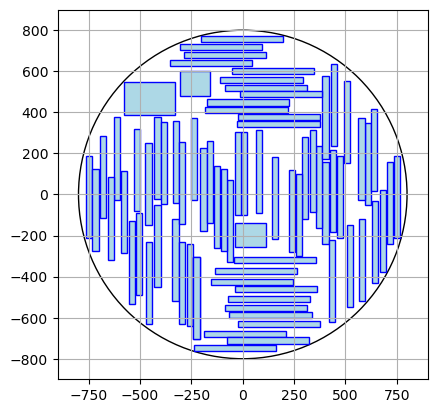

best_best_iteration 27 score 30680
best_mean_iteration 31 score 30286.4


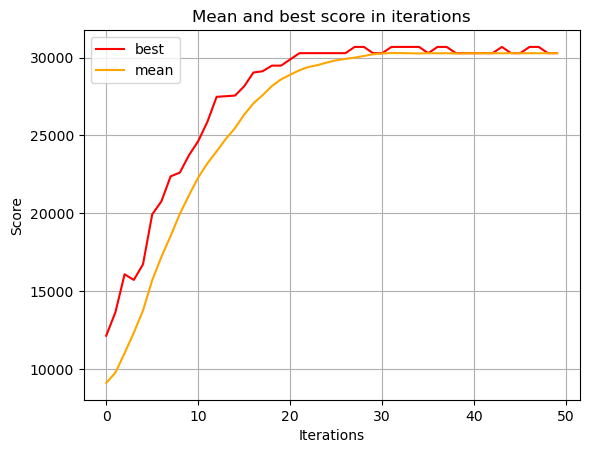

In [169]:
top_count = 25

for i, run in enumerate(best_history_record):
    plt.plot(run, alpha=0.3, color='blue')

plt.xlabel("Iteracja")
plt.ylabel("Wynik (fitness)")
plt.title('Wyniki 64 prób w czasie')
plt.show()

final_scores = [run[-1] for run in best_history_record]
top_indices = np.argsort(final_scores)[-top_count:]  
top_params = np.empty(shape=(top_count, 11), dtype=object)

for i, top_indice in enumerate(top_indices):
    plt.plot(best_history_record[top_indice], label=f"Próba {top_indice}")
    top_params[i, :] = np.array(param_grid[top_indice]).reshape((1, 11))

plt.xlabel("Iteracja")
plt.ylabel("Wynik")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title('Top 25 prób')
plt.show()

print('population_size', top_params[:, 0])
print('initiation_size', top_params[:, 1])
print('iterations_num', top_params[:, 2])
print('selection_type', top_params[:, 3])
print('draft_size', top_params[:, 4])
print('elite_ratio', top_params[:, 5])
print('crossbreed_type', top_params[:, 6])
print('mutation_prob', top_params[:, 7])
print('max_translation_step', top_params[:, 8])
print('translation_variants_number', top_params[:, 9])
print('addition_variants_number', top_params[:, 10])

idx = top_indices[top_count-1]
check_solution(1600, best_history_record[idx], mean_history_record[idx], best_speciment_record[idx])

**Dominuje:**
- Selekcja turniejowa  
- Większa populacja i liczba prostokątów w inicjacji  
- Szansa mutacji na poziomie 0.45  
- Brak selekcji elitarnej  

**Nie znaleziono znaczenia:**
- Parametrów technicznych mutowania: intuicyjnie wymuszenie większej liczby losowych prób mutacji powinno zwiększać szanse na udane przesunięcie starych lub dodanie nowego prostokąta, jednak w praktyce najlepsze modele tego nie wykazują  
- Ilości osobników dobieranych do porównania w selekcji turniejowej (2 vs 3)  


# r850

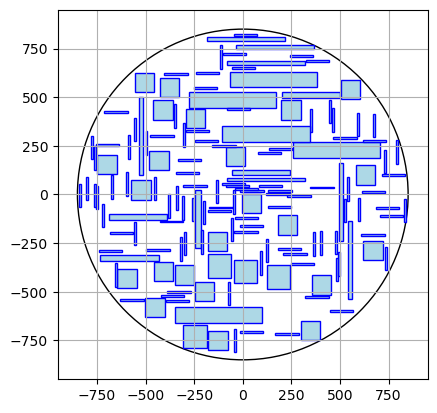

best_best_iteration 0 score 109360
best_mean_iteration 0 score 74513.84


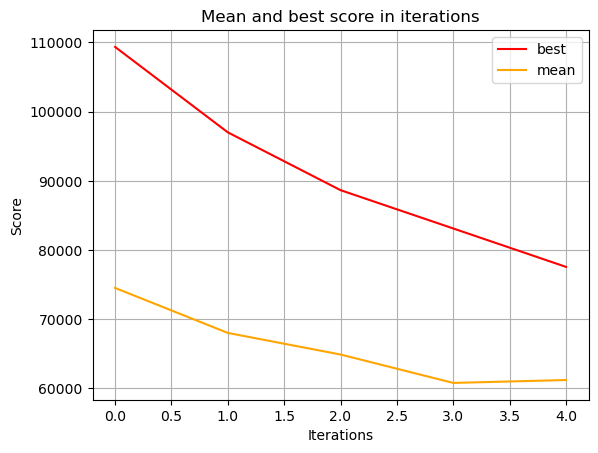

In [4]:
test = genetic_cutting(task_file='cutting/r850.csv', 
                       diameter=1700,
                        population_size=125,
                        initiation_size=750)

best_history, mean_history, best_speciment = test.evolve(iterations_num=5,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=30,
			translation_variants_number=100,
			addition_variants_number=100)

check_solution(1700, best_history, mean_history, best_speciment)

print('liczba prostokątów:', len(best_speciment))
print('średnia punktacja prostokątów w puli', np.mean(r850[['score']]))
print('wynik osobnika ze średnią punktacją', len(best_speciment) * np.mean(r850[['score']]))

# r1000

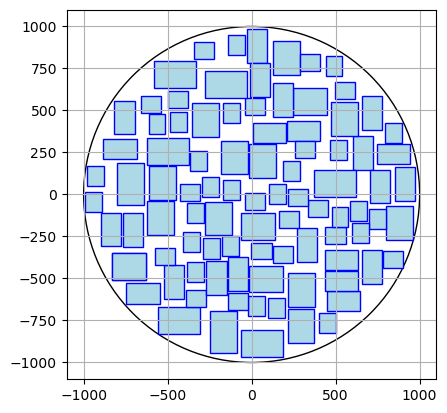

best_best_iteration 80 score 15200
best_mean_iteration 92 score 14887.84


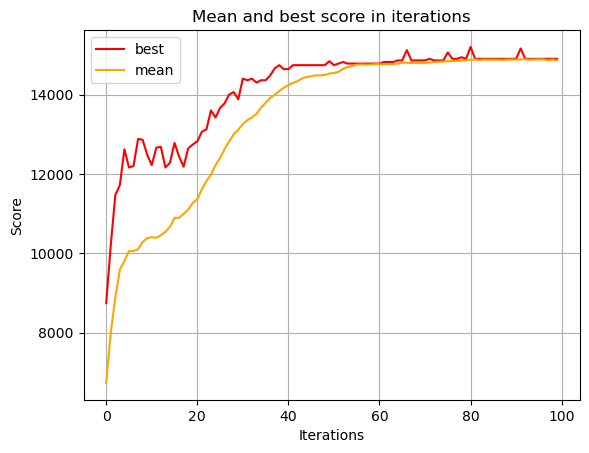

In [60]:
test = genetic_cutting(task_file='cutting/r1000.csv', 
                       diameter=2000,
                        population_size=125,
                        initiation_size=50)

best_history, mean_history, best_speciment = test.evolve(iterations_num=100,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=20,
			translation_variants_number=150,
			addition_variants_number=50)

check_solution(2000, best_history, mean_history, best_speciment)

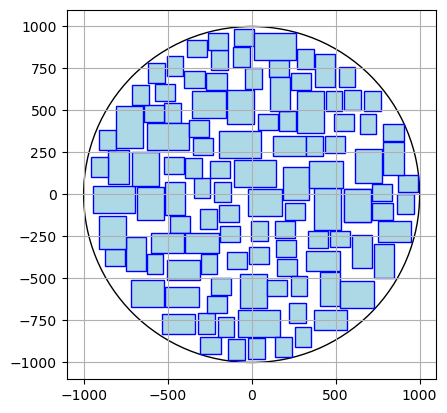

best_best_iteration 427 score 15060
best_mean_iteration 420 score 14755.52


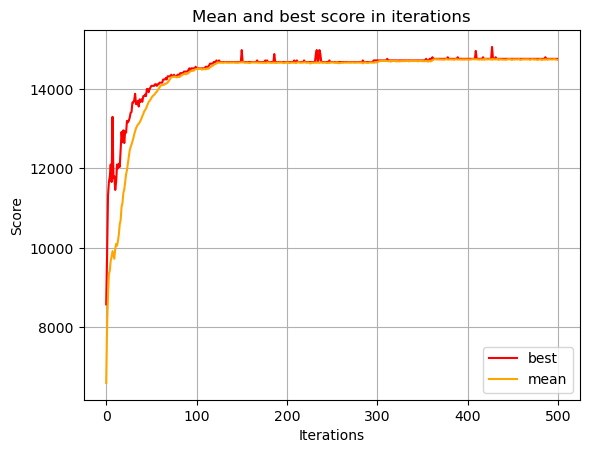

In [68]:
test = genetic_cutting(task_file='cutting/r1000.csv', 
                       diameter=2000,
                        population_size=125,
                        initiation_size=50)

best_history, mean_history, best_speciment = test.evolve(iterations_num=500,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=20,
			translation_variants_number=150,
			addition_variants_number=50)

check_solution(2000, best_history, mean_history, best_speciment)

# r1100

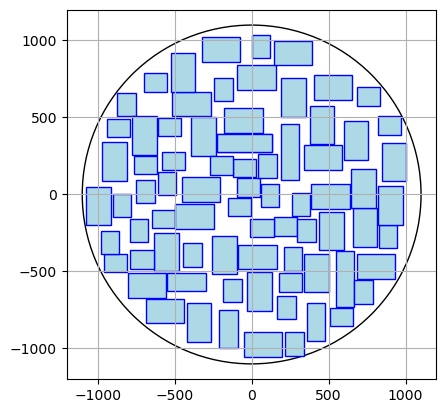

best_best_iteration 49 score 22780
best_mean_iteration 99 score 22679.84


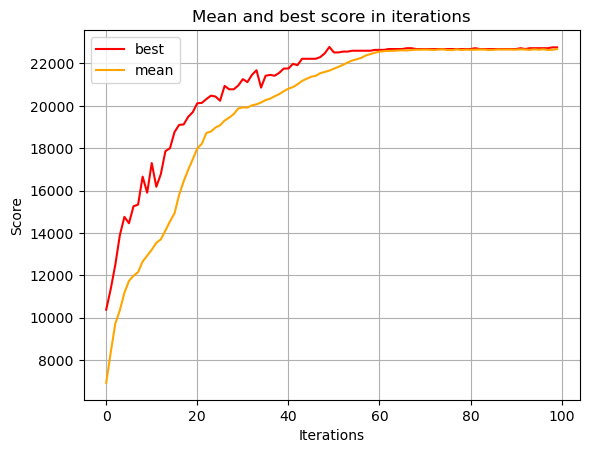

liczba prostokątów: 77
średnia punktacja prostokątów w puli 260.0
wynik osobnika ze średnią punktacją 20020.0


In [ ]:
test = genetic_cutting(task_file='cutting/r1100.csv', 
                       diameter=2200,
                        population_size=125,
                        initiation_size=50)

best_history, mean_history, best_speciment = test.evolve(iterations_num=100,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=30,
			translation_variants_number=100,
			addition_variants_number=100)

check_solution(2200, best_history, mean_history, best_speciment)

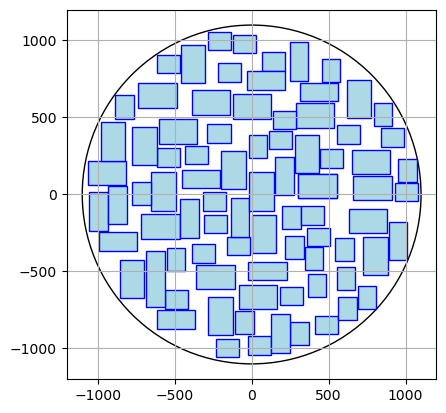

best_best_iteration 44 score 18980
best_mean_iteration 90 score 18886.4


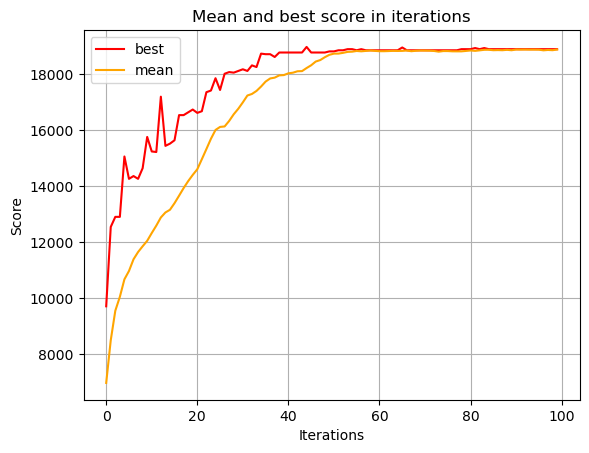

In [66]:
test = genetic_cutting(task_file='cutting/r1100.csv', 
                       diameter=2200,
                        population_size=125,
                        initiation_size=50)

best_history, mean_history, best_speciment = test.evolve(iterations_num=100,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=20,
			translation_variants_number=150,
			addition_variants_number=50)

check_solution(2200, best_history, mean_history, best_speciment)

# r1200

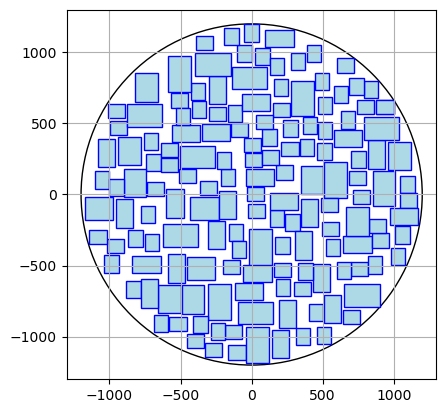

best_best_iteration 84 score 20120
best_mean_iteration 95 score 20072.64


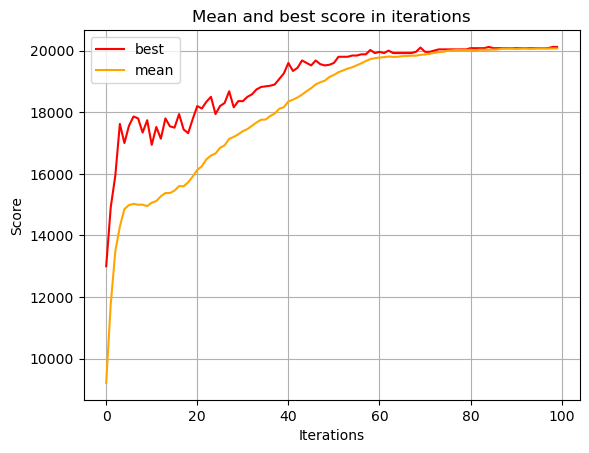

liczba prostokątów: 151
średnia punktacja prostokątów w puli 260.0
wynik osobnika ze średnią punktacją 39260.0


In [ ]:
test = genetic_cutting(task_file='cutting/r1200.csv', 
                       diameter=2400,
                        population_size=125, 
                        initiation_size=50)

best_history, mean_history, best_speciment = test.evolve(iterations_num=100,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=30,
			translation_variants_number=100,
			addition_variants_number=100)

check_solution(2400, best_history, mean_history, best_speciment)

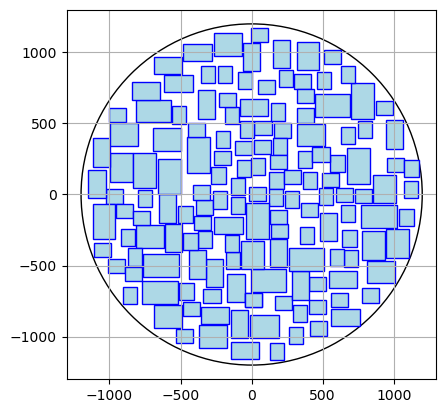

best_best_iteration 95 score 20260
best_mean_iteration 97 score 20209.6


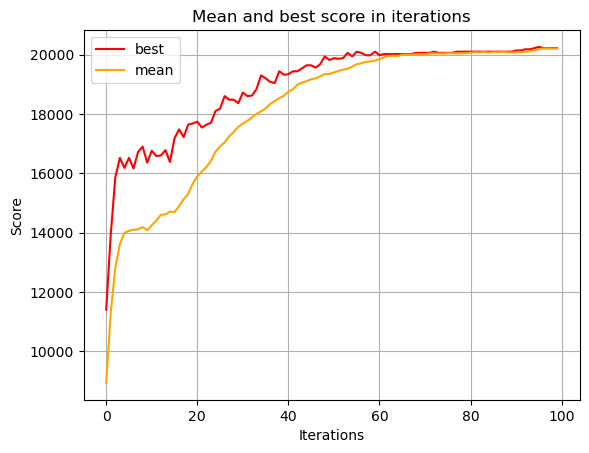

In [67]:
test = genetic_cutting(task_file='cutting/r1200.csv', 
                       diameter=2400,
                        population_size=125, 
                        initiation_size=50)

best_history, mean_history, best_speciment = test.evolve(iterations_num=100,
			selection_type='tournament',
			draft_size=2,
			elite_ratio=None,
			crossbreed_type='naive',
			mutation_prob=0.45,
			max_translation_step=20,
			translation_variants_number=150,
			addition_variants_number=50)

check_solution(2400, best_history, mean_history, best_speciment)

**Wnioski:**
- Po wykonaniu przykładu r800 zdałem sobie sprawę, że przy testach mutacji zablokowałem je na wykonywanie tylko rotacji. Przygotowany algorytm nawet tak upośledzony, dzięki grid search, potrafił osiągnąć wynik 30k punktów. Wnioski z niego płynące były poprawne z wyjątkiem parametrów mutacji.
- W kolejnych zbiorach, już ręcznie, ustaliłem, że parametry mutacji są bardzo ważne. Przy dopuszczaniu dużej liczby prób dodawania prostokątów algorytm na siłe wciska mniejsze co blokuje go w nieoptymalnym stanie. Gdy obniżymy 'addition_variants_number' wyniki są lepsze.  
- Parametr 'max_translation_step' nie wpływa na ostateczny wynik. Jego wielkość określa jedynie tępo zbiegania do stabilnej punktacji. 
- Z kolei pozostawienie dużego 'translation_variants_number' poprawia wynik, bo każde satysfakcjonujące ułożenie musi mieć wysoki "współczynnik upakownia" (małe odstępy), a gdy pozwalamy sobie na więcej prób przesunięcia szansa na udane zbliżenie do siebie prostokątów rośnie. 

In [6]:
population_size_space = [125]
initiation_size_space = [50, 75]
iterations_space = [80]

other_selection_space = ['roulette', 'rank']
other_draft_size_space = [None]

tournament_selection_space = ['tournament']
tournament_draft_size_space = [2, 3]

elite_ratio_space = [None, 0.05]
crossbreed_type_space = ['naive']
mutation_prob_space = [0.45, 0.55]
max_translation_step_space = [20]
translation_variants_number_space = [150]
addition_variants_number_space = [50]

other_param_grid = list(product(
    population_size_space,
    initiation_size_space,
    iterations_space,
    other_selection_space,
    other_draft_size_space,
    elite_ratio_space,
    crossbreed_type_space,
    mutation_prob_space,
    max_translation_step_space,
    translation_variants_number_space,
    addition_variants_number_space,
))

tournament_param_grid = list(product(
    population_size_space,
    initiation_size_space,
    iterations_space,
    tournament_selection_space,
    tournament_draft_size_space,
    elite_ratio_space,
    crossbreed_type_space,
    mutation_prob_space,
    max_translation_step_space,
    translation_variants_number_space,
    addition_variants_number_space,
))

param_grid = other_param_grid + tournament_param_grid

combinations_count = len(param_grid)
print('Liczba kombinacji:', combinations_count)
print('Czas dla 30 iteracji(21s):', combinations_count * 5 / 60, 'h')

Liczba kombinacji: 32
Czas dla 30 iteracji(21s): 2.6666666666666665 h


## r1000 grid search

In [8]:
r1000_best_history_record, r1000_mean_history_record, r1000_best_speciment_record = grid_search(param_grid = param_grid, task_file='cutting/r1000.csv', diameter=2000)

Progress: 100%|██████████| 32/32 [1:56:58<00:00, 219.33s/it]  


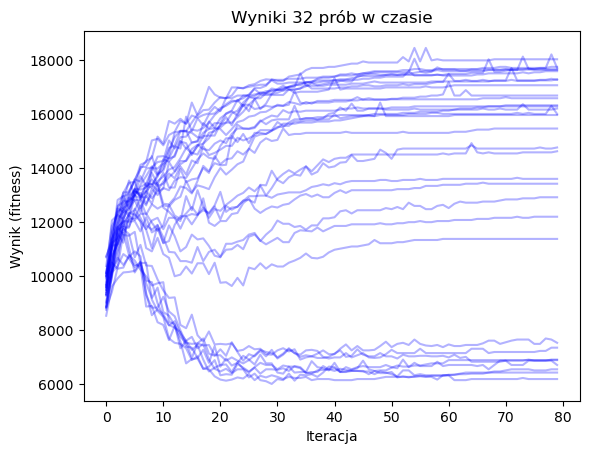

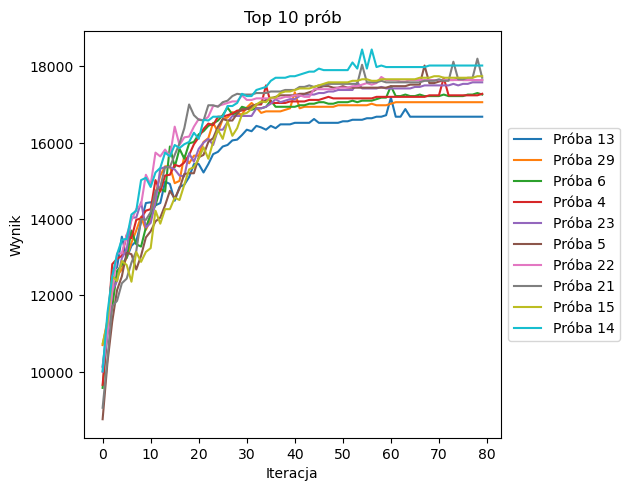

population_size [125 125 125 125 '125' 125 '125' 125 125 125]
initiation_size [75 75 50 50 '50' 50 '50' 50 75 75]
iterations_num [80 80 80 80 '80' 80 '80' 80 80 80]
selection_type ['rank' 'tournament' 'rank' 'rank' 'tournament' 'rank' 'tournament'
 'tournament' 'rank' 'rank']
draft_size [None 3 None None '3' None '3' 3 None None]
elite_ratio [None None 0.05 None '0.05' None '0.05' None 0.05 0.05]
crossbreed_type ['naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive'
 'naive']
mutation_prob [0.55 0.55 0.45 0.45 '0.55' 0.55 '0.45' 0.55 0.55 0.45]
max_translation_step [20 20 20 20 '20' 20 '20' 20 20 20]
translation_variants_number [150 150 150 150 '150' 150 '150' 150 150 150]
addition_variants_number [50 50 50 50 '50' 50 '50' 50 50 50]


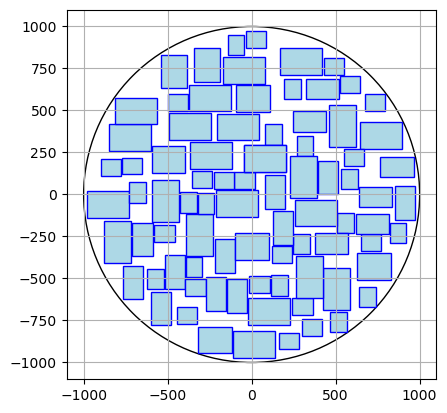

best_best_iteration 54 score 18440
best_mean_iteration 74 score 17386.56


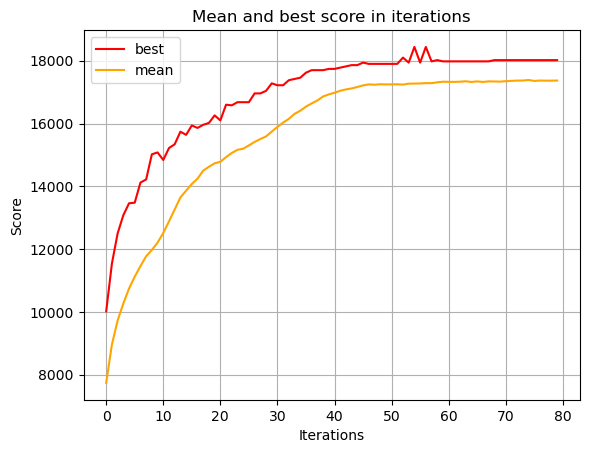

In [10]:
top_count = 10
best_history_record = r1000_best_history_record
mean_history_record = r1000_mean_history_record
best_speciment_record = r1000_best_speciment_record

for i, run in enumerate(best_history_record):
    plt.plot(run, alpha=0.3, color='blue')

plt.xlabel("Iteracja")
plt.ylabel("Wynik (fitness)")
plt.title('Wyniki 32 prób w czasie')
plt.show()

final_scores = [run[-1] for run in best_history_record]
top_indices = np.argsort(final_scores)[-top_count:]  
top_params = np.empty(shape=(top_count, 11), dtype=object)

for i, top_indice in enumerate(top_indices):
    plt.plot(best_history_record[top_indice], label=f"Próba {top_indice}")
    top_params[i, :] = np.array(param_grid[top_indice]).reshape((1, 11))

plt.xlabel("Iteracja")
plt.ylabel("Wynik")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title('Top 10 prób')
plt.show()

print('population_size', top_params[:, 0])
print('initiation_size', top_params[:, 1])
print('iterations_num', top_params[:, 2])
print('selection_type', top_params[:, 3])
print('draft_size', top_params[:, 4])
print('elite_ratio', top_params[:, 5])
print('crossbreed_type', top_params[:, 6])
print('mutation_prob', top_params[:, 7])
print('max_translation_step', top_params[:, 8])
print('translation_variants_number', top_params[:, 9])
print('addition_variants_number', top_params[:, 10])

idx = top_indices[top_count-1]
check_solution(2000, best_history_record[idx], mean_history_record[idx], best_speciment_record[idx])

## r1100 grid search

In [11]:
r1100_best_history_record, r1100_mean_history_record, r1100_best_speciment_record = grid_search(param_grid = param_grid, task_file='cutting/r1100.csv', diameter=2200)

Progress: 100%|██████████| 32/32 [1:22:48<00:00, 155.28s/it]


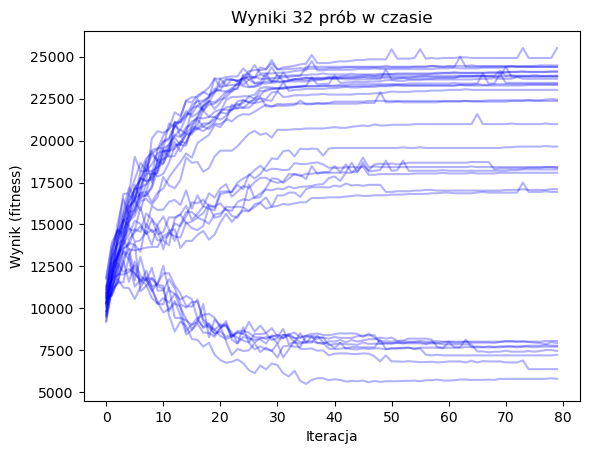

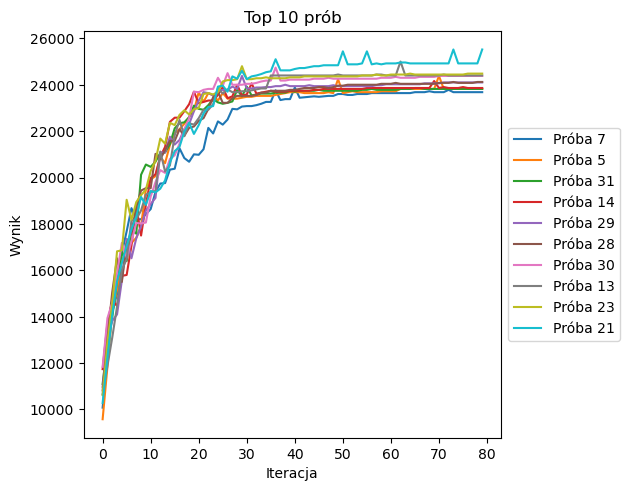

population_size [125 125 '125' 125 125 125 '125' 125 '125' 125]
initiation_size [50 50 '75' 75 75 75 '75' 75 '50' 50]
iterations_num [80 80 '80' 80 80 80 '80' 80 '80' 80]
selection_type ['rank' 'rank' 'tournament' 'rank' 'tournament' 'tournament' 'tournament'
 'rank' 'tournament' 'tournament']
draft_size [None None '3' None 3 3 '3' None '3' 3]
elite_ratio [0.05 None '0.05' 0.05 None None '0.05' None '0.05' None]
crossbreed_type ['naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive'
 'naive']
mutation_prob [0.55 0.55 '0.55' 0.45 0.55 0.45 '0.45' 0.55 '0.55' 0.55]
max_translation_step [20 20 '20' 20 20 20 '20' 20 '20' 20]
translation_variants_number [150 150 '150' 150 150 150 '150' 150 '150' 150]
addition_variants_number [50 50 '50' 50 50 50 '50' 50 '50' 50]


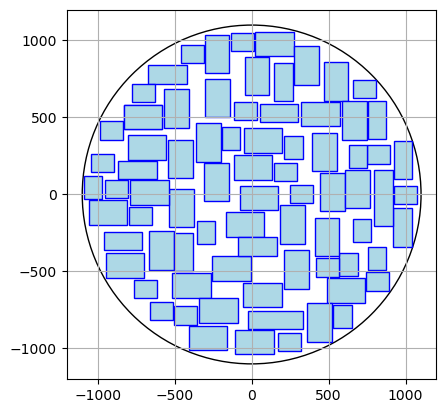

best_best_iteration 73 score 25520
best_mean_iteration 74 score 24906.4


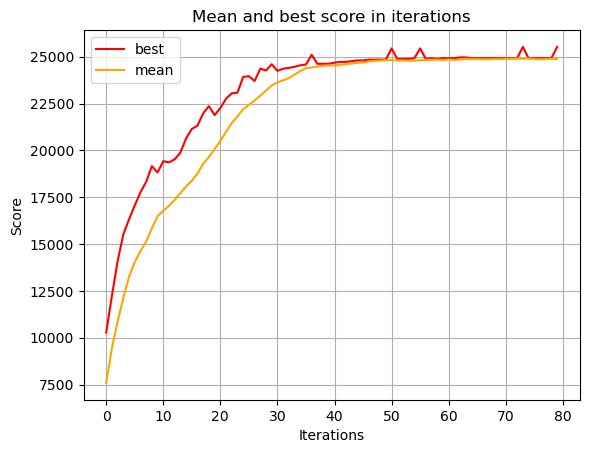

In [12]:
top_count = 10
best_history_record = r1100_best_history_record
mean_history_record = r1100_mean_history_record
best_speciment_record = r1100_best_speciment_record

for i, run in enumerate(best_history_record):
    plt.plot(run, alpha=0.3, color='blue')

plt.xlabel("Iteracja")
plt.ylabel("Wynik (fitness)")
plt.title('Wyniki 32 prób w czasie')
plt.show()

final_scores = [run[-1] for run in best_history_record]
top_indices = np.argsort(final_scores)[-top_count:]  
top_params = np.empty(shape=(top_count, 11), dtype=object)

for i, top_indice in enumerate(top_indices):
    plt.plot(best_history_record[top_indice], label=f"Próba {top_indice}")
    top_params[i, :] = np.array(param_grid[top_indice]).reshape((1, 11))

plt.xlabel("Iteracja")
plt.ylabel("Wynik")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title('Top 10 prób')
plt.show()

print('population_size', top_params[:, 0])
print('initiation_size', top_params[:, 1])
print('iterations_num', top_params[:, 2])
print('selection_type', top_params[:, 3])
print('draft_size', top_params[:, 4])
print('elite_ratio', top_params[:, 5])
print('crossbreed_type', top_params[:, 6])
print('mutation_prob', top_params[:, 7])
print('max_translation_step', top_params[:, 8])
print('translation_variants_number', top_params[:, 9])
print('addition_variants_number', top_params[:, 10])

idx = top_indices[top_count-1]
check_solution(2200, best_history_record[idx], mean_history_record[idx], best_speciment_record[idx])

## r1200 grid search

In [13]:
r1200_best_history_record, r1200_mean_history_record, r1200_best_speciment_record = grid_search(param_grid = param_grid, task_file='cutting/r1200.csv', diameter=2400)

Progress: 100%|██████████| 32/32 [3:56:43<00:00, 443.87s/it]  


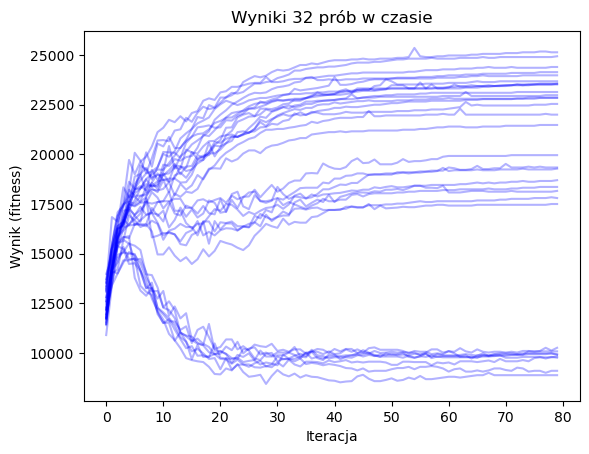

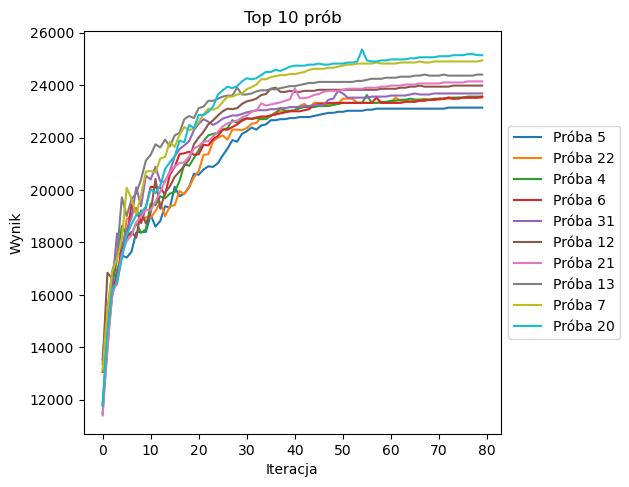

population_size [125 '125' 125 125 '125' 125 125 125 125 125]
initiation_size [50 '50' 50 50 '75' 75 50 75 50 50]
iterations_num [80 '80' 80 80 '80' 80 80 80 80 80]
selection_type ['rank' 'tournament' 'rank' 'rank' 'tournament' 'rank' 'tournament' 'rank'
 'rank' 'tournament']
draft_size [None '3' None None '3' None 3 None None 3]
elite_ratio [None '0.05' None 0.05 '0.05' None None None 0.05 None]
crossbreed_type ['naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive' 'naive'
 'naive']
mutation_prob [0.55 '0.45' 0.45 0.45 '0.55' 0.45 0.55 0.55 0.55 0.45]
max_translation_step [20 '20' 20 20 '20' 20 20 20 20 20]
translation_variants_number [150 '150' 150 150 '150' 150 150 150 150 150]
addition_variants_number [50 '50' 50 50 '50' 50 50 50 50 50]


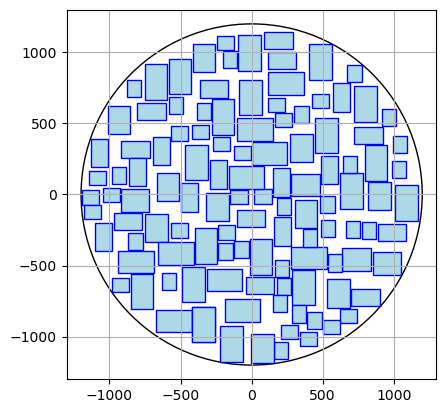

best_best_iteration 54 score 25360
best_mean_iteration 79 score 25122.56


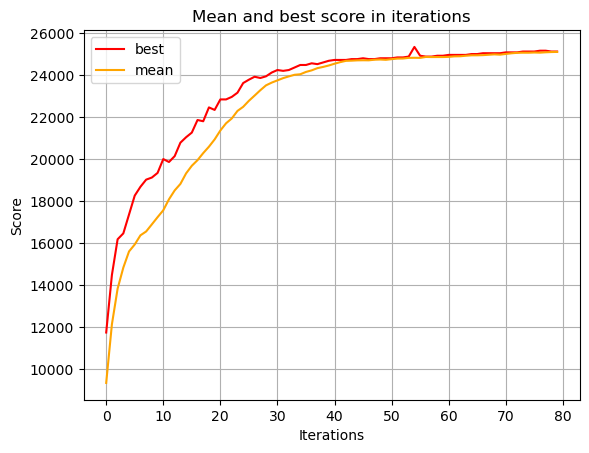

In [14]:
top_count = 10
best_history_record = r1200_best_history_record
mean_history_record = r1200_mean_history_record
best_speciment_record = r1200_best_speciment_record

for i, run in enumerate(best_history_record):
    plt.plot(run, alpha=0.3, color='blue')

plt.xlabel("Iteracja")
plt.ylabel("Wynik (fitness)")
plt.title('Wyniki 32 prób w czasie')
plt.show()

final_scores = [run[-1] for run in best_history_record]
top_indices = np.argsort(final_scores)[-top_count:]  
top_params = np.empty(shape=(top_count, 11), dtype=object)

for i, top_indice in enumerate(top_indices):
    plt.plot(best_history_record[top_indice], label=f"Próba {top_indice}")
    top_params[i, :] = np.array(param_grid[top_indice]).reshape((1, 11))

plt.xlabel("Iteracja")
plt.ylabel("Wynik")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.title('Top 10 prób')
plt.show()

print('population_size', top_params[:, 0])
print('initiation_size', top_params[:, 1])
print('iterations_num', top_params[:, 2])
print('selection_type', top_params[:, 3])
print('draft_size', top_params[:, 4])
print('elite_ratio', top_params[:, 5])
print('crossbreed_type', top_params[:, 6])
print('mutation_prob', top_params[:, 7])
print('max_translation_step', top_params[:, 8])
print('translation_variants_number', top_params[:, 9])
print('addition_variants_number', top_params[:, 10])

idx = top_indices[top_count-1]
check_solution(2400, best_history_record[idx], mean_history_record[idx], best_speciment_record[idx])